In [5]:
import sys
import numpy
import pandas
import matplotlib
import seaborn
import scipy

print('Python: {}'.format(sys.version))
print('Numpy: {}'.format(numpy.__version__))
print('Pandas: {}'.format(pandas.__version__))
print('Matplotlib: {}'.format(matplotlib.__version__))
print('Seaborn: {}'.format(seaborn.__version__))
print('Scipy: {}'.format(scipy.__version__))


Python: 3.7.1 (default, Dec 14 2018, 13:28:58) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
Numpy: 1.17.2
Pandas: 0.25.1
Matplotlib: 3.1.1
Seaborn: 0.9.0
Scipy: 1.3.1


In [6]:
# import the necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
# Load the dataset from the csv file using pandas
data = pd.read_csv("creditcard.csv")

In [8]:
# Start exploring the dataset
print(data.columns)

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


In [9]:
# Print the shape of the data
data = data.sample(frac=0.1, random_state = 1)
print(data.shape)
print(data.describe())

# V1 - V28 are the results of a PCA Dimensionality reduction to protect user identities and sensitive features

(1594, 31)
               Time           V1           V2           V3           V4  \
count   1594.000000  1594.000000  1594.000000  1594.000000  1594.000000   
mean   12102.264115    -0.345735     0.338256     0.743597     0.268992   
std     8960.892575     2.137663     1.542351     2.104545     1.513570   
min        2.000000   -23.237920   -15.295396   -25.188773    -3.669308   
25%     3712.250000    -1.046300    -0.285684     0.343919    -0.652703   
50%    11012.000000    -0.348466     0.258240     0.944230     0.213851   
75%    20519.750000     1.155648     0.905630     1.584314     1.163833   
max    27356.000000     1.580440    13.487386     4.029428    11.786180   

                V5           V6           V7           V8           V9  ...  \
count  1594.000000  1594.000000  1594.000000  1594.000000  1594.000000  ...   
mean     -0.164327     0.111587    -0.215513     0.035699     0.886871  ...   
std       1.487341     1.291853     1.442289     1.579598     1.266841  ... 

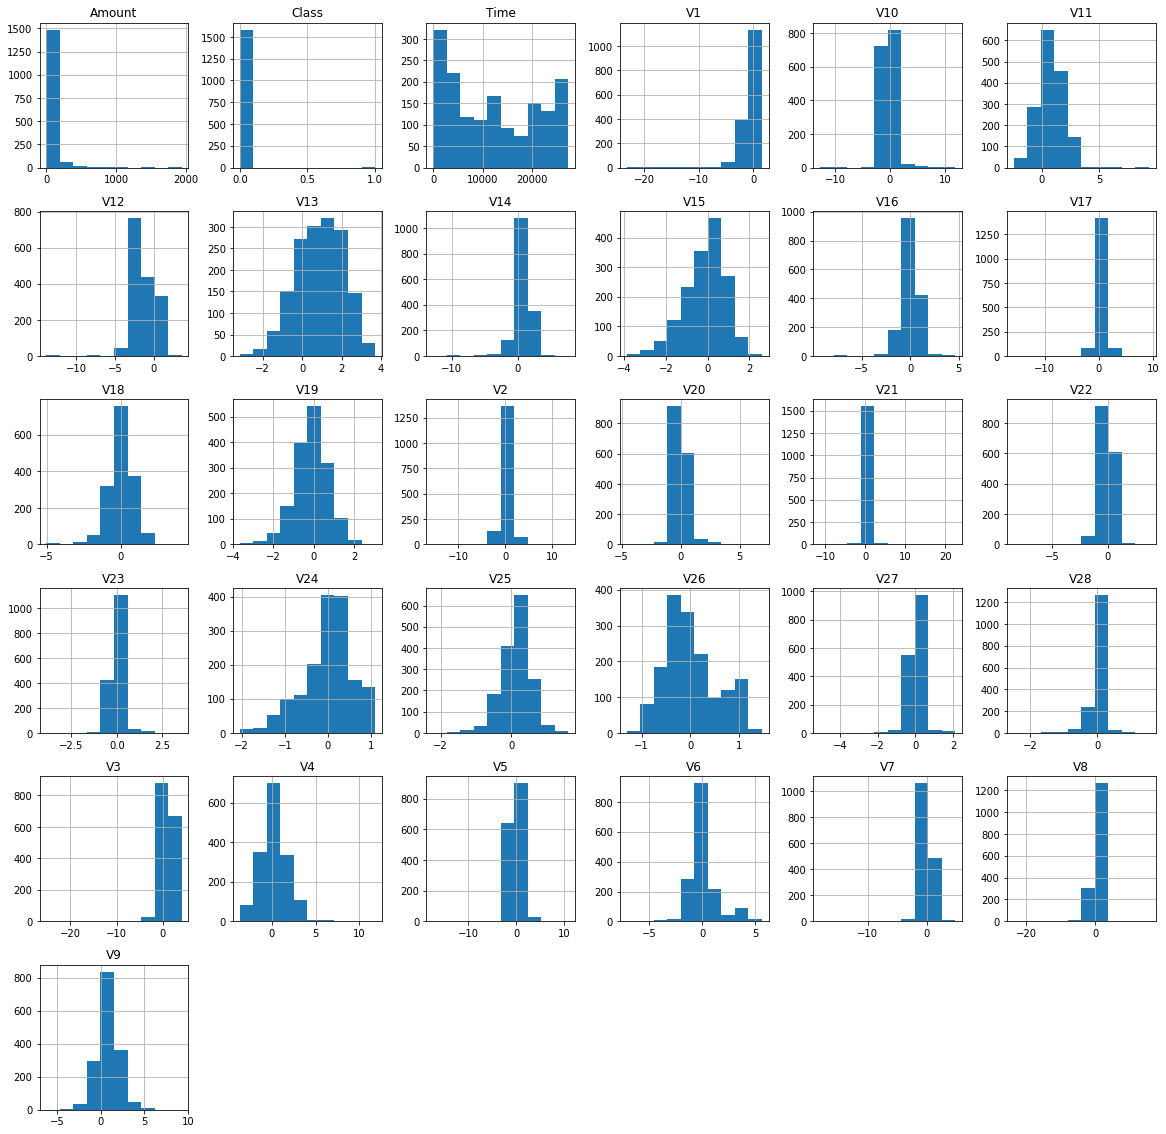

In [10]:
# Plot histograms of each parameter 
data.hist(figsize = (20, 20))
plt.show()

In [15]:
# Determine number of fraud cases in dataset

Fraud = data[data['Class'] == 1]
Valid = data[data['Class'] == 0]

outlier_fraction = len(Fraud)/float(len(Valid))
print(outlier_fraction)

print('Fraud Cases: {}'.format(len(data[data['Class'] == 1])))
print('Valid Transactions: {}'.format(len(data[data['Class'] == 0])))



0.0017234102419808666
Fraud Cases: 49
Valid Transactions: 28432


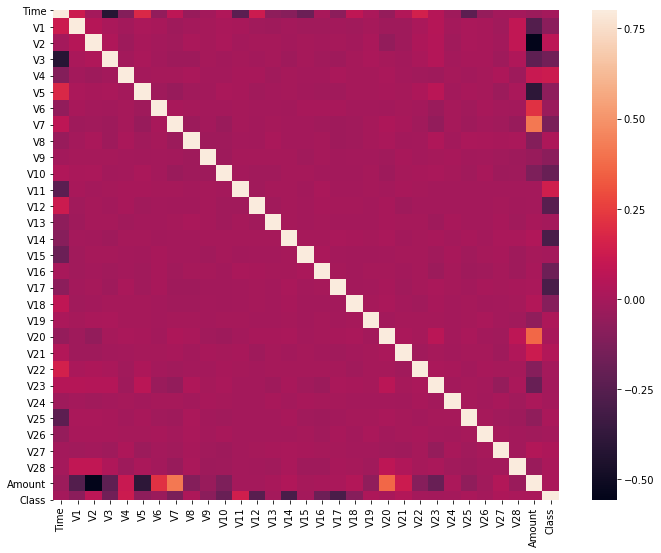

In [20]:
# Correlation matrix
corrmat = data.corr()
fig = plt.figure(figsize = (12, 9))

sns.heatmap(corrmat, vmax = .8, square = True)
plt.show()

In [21]:
# Get all the columns from the dataFrame
columns = data.columns.tolist()

# Filter the columns to remove data we do not want
columns = [c for c in columns if c not in ["Class"]]

# Store the variable we'll be predicting on
target = "Class"

X = data[columns]
Y = data[target]

# Print shapes
print(X.shape)
print(Y.shape)

(28481, 30)
(28481,)


## 3. Unsupervised Outlier Detection

Now that we have processed our data, we can begin deploying our machine learning algorithms.  We will use the following techniques: 

**Local Outlier Factor (LOF)**

The anomaly score of each sample is called Local Outlier Factor. It measures the local deviation of density of a 
given sample with respect to its neighbors. It is local in that the anomaly score depends on how isolated the 
object is with respect to the surrounding neighborhood.


**Isolation Forest Algorithm**

The IsolationForest ‘isolates’ observations by randomly selecting a feature and then randomly selecting 
a split value between the maximum and minimum values of the selected feature.

Since recursive partitioning can be represented by a tree structure, the number of splittings required to 
isolate a sample is equivalent to the path length from the root node to the terminating node.

This path length, averaged over a forest of such random trees, is a measure of normality and our decision function.

Random partitioning produces noticeably shorter paths for anomalies. Hence, when a forest of random trees 
collectively produce shorter path lengths for particular samples, they are highly likely to be anomalies.

In [22]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

# define random states
state = 1

# define outlier detection tools to be compared
classifiers = {
    "Isolation Forest": IsolationForest(max_samples=len(X),
                                        contamination=outlier_fraction,
                                        random_state=state),
    "Local Outlier Factor": LocalOutlierFactor(
        n_neighbors=20,
        contamination=outlier_fraction)}

In [23]:
# Fit the model
plt.figure(figsize=(9, 7))
n_outliers = len(Fraud)


for i, (clf_name, clf) in enumerate(classifiers.items()):
    
    # fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_pred = clf.negative_outlier_factor_
    else:
        clf.fit(X)
        scores_pred = clf.decision_function(X)
        y_pred = clf.predict(X)
    
    # Reshape the prediction values to 0 for valid, 1 for fraud. 
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    
    n_errors = (y_pred != Y).sum()
    
    # Run classification metrics
    print('{}: {}'.format(clf_name, n_errors))
    print(accuracy_score(Y, y_pred))
    print(classification_report(Y, y_pred))


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Isolation Forest: 71
0.99750711000316
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.28      0.29      0.28        49

    accuracy                           1.00     28481
   macro avg       0.64      0.64      0.64     28481
weighted avg       1.00      1.00      1.00     28481

Local Outlier Factor: 97
0.9965942207085425
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.02      0.02      0.02        49

    accuracy                           1.00     28481
   macro avg       0.51      0.51      0.51     28481
weighted avg       1.00      1.00      1.00     28481



<Figure size 648x504 with 0 Axes>